# Essentially, testing out my pipeline

In [ ]:
%load_ext autoreload
%autoreload 2

In [5]:
import os, pickle
import numpy as np
import matplotlib.pyplot as plt
from cv2 import SIFT_create, imread, cvtColor, COLOR_BGR2GRAY, GaussianBlur
from skimage.io import imread

from scripts.utils import extract_frames_info
from scripts.display_utils import show_image_with_bbs
from scripts.hog.classifier import HOGClassifier


In [3]:
frames_info = extract_frames_info("data/train.csv")

In [16]:
classifier = HOGClassifier()

features, labels = classifier.features_labels(frames_info[:10], 1)

100%|██████████| 10/10 [00:00<00:00, 10010.27it/s]


In [19]:
features[1].shape

(34560,)

In [31]:
with open("models/hog/non_linear_stricter_64_8.pkl", "rb") as pickle_file:
    classifier = pickle.load(pickle_file)

C:\Users\Baptiste Prevot\.pyenv\pyenv-win\versions\3.8.10\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator SVC from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[1]


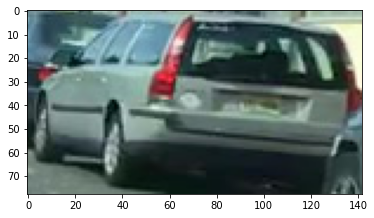

In [25]:
image_index = 100
image = imread(frames_info[image_index][0])

car_index = 5

car_bb = frames_info[image_index][1][car_index]
car_image = image[car_bb[1]: car_bb[1]+car_bb[3], car_bb[0]: car_bb[0]+car_bb[2]]
plt.imshow(car_image)
print(classifier.predict(car_image))

[1]


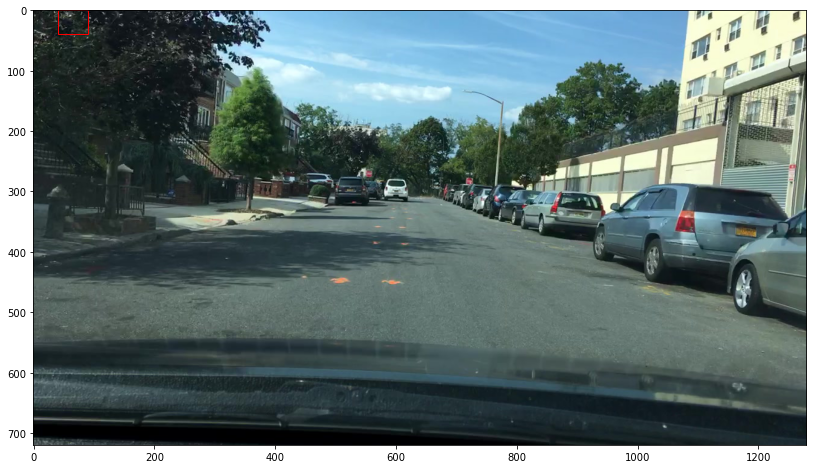

In [66]:
image_index = 100
image = imread(frames_info[image_index][0])

car_bb = [500, 250, 150, 100]
car_image = image[car_bb[1]: car_bb[1]+car_bb[3], car_bb[0]: car_bb[0]+car_bb[2]]
print(classifier.predict(car_image))
show_image_with_bbs(frames_info[image_index][0], [car_bb])

## Testing detection

In [2]:
from scripts.hog.detector import Detector
import pickle
from skimage.io import imread
from scripts.display_utils import show_image_with_bbs

In [6]:
detector = Detector(classifier)
test_dir = "data/test"
test_images = [os.path.join(test_dir, filename) for filename in os.listdir(test_dir)]

NameError: name 'classifier' is not defined

In [7]:
image_index = 40
image = imread(test_images[image_index])

NameError: name 'test_images' is not defined

In [59]:
detections, decisions = detector.detect(
    image, 
    10, 
    [
        64,
        100, 
        200, 
        300,
        # 500
    ], 
    [
        # 1.0, 
        .8, 
        .5
    ])
print(len(detections))

100%|██████████| 8/8 [05:37<00:00, 42.14s/it]

27


In [70]:
best_idx = np.array(decisions) > .2
best_detections = np.array(detections)[best_idx]
best_decisions = np.array(decisions)[best_idx]

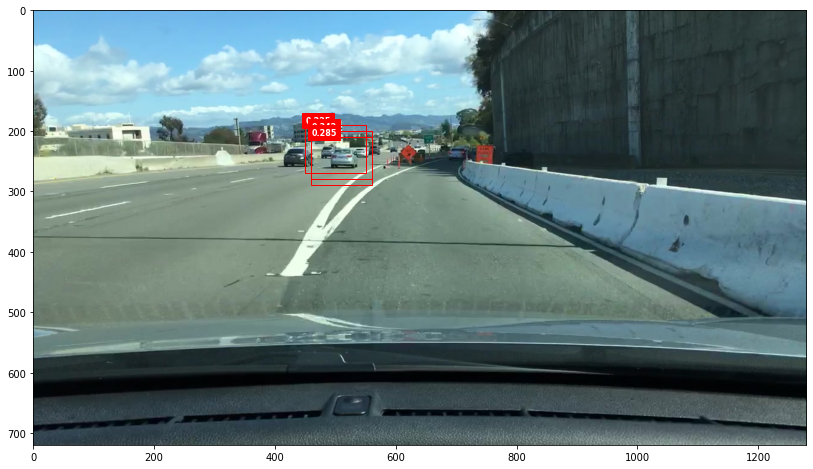

In [71]:
show_image_with_bbs(test_images[image_index], best_detections, confidences=[f"{score:.3f}" for score in best_decisions])


In [26]:
print(decisions)

[0.1359608450905696, 0.03332532112075448, 0.051847289964692234]


## Hard example mining

In [1]:
from scripts.hog.bounding_box_utils import find_free_window
from random import choice
from tqdm.auto import tqdm

/gpfs/users/prevotb/.conda/envs/opencv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
WINDOW_WIDTHS, WINDOW_RATIOS = [64, 128, 256, 400], [.8, 0.5, 1.0]

WINDOW_SHAPES = [(width, int(width*ratio)) for width in WINDOW_WIDTHS for ratio in WINDOW_RATIOS]
def mine_hard_example(image_path, bboxes, n_examples, classifier):
    pbar = tqdm()
    examples = []
    image = imread(image_path)
    while len(examples) < n_examples:
        window = find_free_window((image.shape[1], image.shape[0]), bboxes, choice(WINDOW_SHAPES))
        if window is None:
            continue
        sub_image = image[window[1]: window[1]+window[3], window[0]: window[0]+window[2]]
        label, feature_vect = classifier.predict(sub_image, True)
        if label:
            examples.append(feature_vect)
            plt.imshow(sub_image)
            plt.show()
            pbar.update()
    pbar.close()
    return examples

0it [00:00, ?it/s]

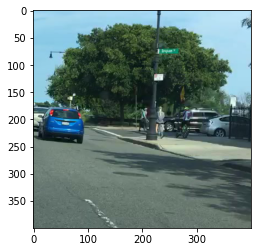

1it [00:08,  8.35s/it]

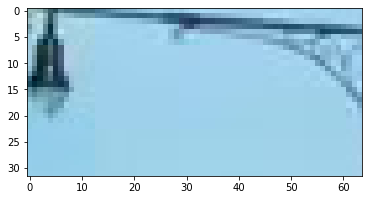

2it [01:14, 42.10s/it]

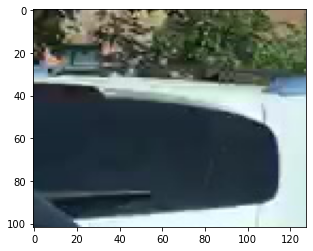

3it [01:26, 28.82s/it]

3


In [7]:
car_index = 0
image_path, bboxes = frames_info[car_index]

hard_examples = mine_hard_example(image_path, bboxes, 3, classifier)
print(len(hard_examples))

## Visualizing final results

In [1]:
from ipywidgets import interact, widgets
from scripts.display_utils import show_image_with_bbs
import pickle
import numpy as np
from scripts.hog.detector import Detector

In [2]:
with open("results/hog/linear_results.pkl", "rb") as pickle_file:
    results = pickle.load(pickle_file)


all_filenames, all_detections, all_confidences = [None]*len(results), [None]*len(results), [None]*len(results)
for fname, _, detections, confidences in results:
    idx = int(fname.split(".")[0]) - 1
    all_filenames[idx] = fname
    all_detections[idx] = detections
    all_confidences[idx] = confidences

In [21]:
detector = Detector(None, nms_mode="confidence")
def f_display(index):
    detections = all_detections[index]
    confidences = all_confidences[index]
    best_idx = np.array(confidences) > .2
    best_detections = np.array(detections)[best_idx]
    # best_confidences = [f"{score:.3f}" for score in np.array(confidences)[best_idx]]
    best_detections = detector.nms(best_detections, .5, "min", np.array(confidences)[best_idx])
    show_image_with_bbs(os.path.join("data/test", all_filenames[index]), best_detections)

interact(f_display, index=widgets.IntSlider(min=0, max=len(all_filenames)-1, step=1, value=63))

interactive(children=(IntSlider(value=63, description='index', max=201), Output()), _dom_classes=('widget-inte…

<function __main__.f_display(index)>

In [22]:
from scripts.utils import run_length_encoding, bounding_boxes_to_mask
import csv

rows = []
for file_name, _, detections, confidences in results:
    correct = [i for i in range(len(detections)) if detections[i][1] > 100 and detections[i][1]+detections[i][3] < 500]
    detections = [det for det in detections if det[1] > 100 and det[1]+det[3] < 500]
    best_idx = np.array(confidences) > .2
    best_detections = np.array(detections)[best_idx]
    best_detections = detector.nms(best_detections, .5, "min", np.array(confidences)[best_idx])
    rle = run_length_encoding(bounding_boxes_to_mask(best_detections, 720, 1280))
    rows.append(['test/' + file_name, rle])

with open("results/hognot_the_worst.csv", "w") as dest_file:
    writer = csv.writer(dest_file)
    writer.writerows(rows)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 26 but corresponding boolean dimension is 33